In [1]:
import re
import numpy as np
import pandas as pd
import time
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
import itertools
import matplotlib.pyplot as plt

In [2]:
films = []
for p in Path("C:/Users/forem/Code/text-as-data/people/Foreman/Adventure").glob('*.txt'):
    with open(p, mode="r", encoding="utf-8") as f:
        film = f.read()
        films.append(film)

In [3]:
tokenized_films = []
for film in films:
    tokenized_film = word_tokenize(film)
    tokenized_films.append(tokenized_film)

# for i, tokenized_film in enumerate(tokenized_films):
#     print(f"Film {i+1}:")
#     for sentence in tokenized_film:
#         print(sentence)

In [4]:
print(f"Number of tokenized films: {len(tokenized_films)}")

Number of tokenized films: 166


In [5]:
# for sentence in tokenized_films[0][:20]:
#     words = re.sub("[^a-zA-Z']"," ", sentence).split()
#     print(" ".join(words))

In [6]:
# # Assuming tokenized_films is a list of tokenized text files
# # Define the chunk sizes
# chunk1_size = 0.25
# chunk2_size = 0.50
# chunk3_size = 0.25

# # Initialize a list to store the chunks for each file
# chunked_tokenized_films = []

# for film in tokenized_films:
#     # Calculate the sizes of each chunk based on the length of the file
#     total_length = len(film)
#     chunk1_end = int(total_length * chunk1_size)
#     chunk2_end = int(total_length * (chunk1_size + chunk2_size))

#     # Divide the file into three chunks
#     chunk1 = film[:chunk1_end]
#     chunk2 = film[chunk1_end:chunk2_end]
#     chunk3 = film[chunk2_end:]

#     # Store the chunks for this file in a tuple
#     chunks = (chunk1, chunk2, chunk3)

#     # Append the tuple to the list of chunked files
#     chunked_tokenized_films.append(chunks)

# # Now chunked_tokenized_films contains the three chunks for each file
# print(chunk3)

In [7]:
def film_chunker(film):
    
    # Tokenize the string
    tokenized_film = word_tokenize(film)

    # Break the list into three lists:
    ## Set our chunk sizes
    chunk1_size = 0.25
    chunk2_size = 0.50
    chunk3_size = 0.25

    # Calculate the sizes of each chunk based on the length of the file
    total_length = len(tokenized_film)
    chunk1_end = int(total_length * chunk1_size)
    chunk2_end = int(total_length * (chunk1_size + chunk2_size))

    # Divide the file into three chunks
    chunk1 = tokenized_film[:chunk1_end]
    chunk2 = tokenized_film[chunk1_end:chunk2_end]
    chunk3 = tokenized_film[chunk2_end:]

    # Store the chunks for this film in a tuple
    chunks = (chunk1, chunk2, chunk3)
    
    return chunks

In [8]:
# pieces = film_chunker(tokenized_films[0])
chunked_films = [ film_chunker(film) for film in films ]

The two code blocks above work together to creat a list of our chunked films which are created by the film_chunker function above. What the film_chunker function does is divide each film into chunks specified, specifically 3 separate acts. 

In [9]:
# What's the top level structure
print(type(chunked_films))

# Okay, it's a list of:
print(type(chunked_films[0]))

# And each tuple is made up of:
print(type(chunked_films[0][0]))

# And the bottom turtle is:
print(type(chunked_films[0][0][0]))

<class 'list'>
<class 'tuple'>
<class 'list'>
<class 'str'>


In [10]:
act1s = []
act2s = []
act3s = []
for item in chunked_films:
    act1s.append(item[0])
    act2s.append(item[1])
    act3s.append(item[2])

Here we're creating empty list based on the chunked films we created with the film_chunker function and separating them into their respective act list.

In [11]:
act_ones = [ x[0] for x in chunked_films ]
act_twos = [ x[1] for x in chunked_films ]
act_threes = [ x[2] for x in chunked_films ]

In [51]:
print(f"The second film in our list is {films[1][80:120]}")
print(f"It's {len(word_tokenize(films[1]))} words long.")
print(f"The first act is {len(act1s[1])}.")

The second film in our list is 

1492: CONQUEST OF PARADISE

          
It's 27918 words long.
The first act is 6979.


The block above allows you to see the length of any film and see how long any act is by changing the text that displays to whatever act you like and by changing the act list it pulls from.

In [13]:
act1_string = str(act_ones)
act2_string = str(act_twos)
act3_string = str(act_threes)
# print(len(act1_string))
type(act1_string)

type(act2_string)

type(act3_string)

str

In [14]:
df_act1 = pd.DataFrame({'act_ones': act_ones})
df_act2 = pd.DataFrame({'act_twos': act_twos})
df_act3 = pd.DataFrame({'act_threes': act_threes})

In [15]:
print(df_act1)

                                              act_ones
0    [127, HOURS, Written, by, Simon, Beaufoy, &, D...
1    [<, b, >, <, !, --, <, /b, >, if, (, window, !...
2    [2001, :, A, SPACE, ODYSSEY, Screenplay, by, S...
3    [2012, Written, by, Roland, Emmerich, &, Haral...
4    [30, MINUTES, OR, LESS, Written, by, Michael, ...
..                                                 ...
161  [<, b, >, <, !, --, <, /b, >, if, (, window, !...
162  [FADE, IN, --, Title, :, For, nearly, forty, y...
163  [T, H, E, W, O, R, L, D, I, S, N, O, T, E, N, ...
164  [``, xXx, '', by, Rich, Wilkes, August, 26, ,,...
165  [YEAR, ONE, Written, by, Harold, Ramis, ,, Gen...

[166 rows x 1 columns]


This was one of the failed matrixes i treid as it instead just had the entire text file as essentially one word within the dataframe instead of each individual word as its own object.

In [16]:
# print(sia.polarity_scores(act1_string))

In [17]:
act1scomp = [" ".join(act1) for act1 in act1s]
act2scomp = [" ".join(act2) for act2 in act2s]
act3scomp = [" ".join(act3) for act3 in act3s]

for act in act1scomp[0:5]:
    print(act[0:10])

In [19]:
type(act1scomp[0])

str

The following blocks below create term frequency matrix for the act specified. Doing so allows a quick view of the type of vocabulary used throughout adventure films and how it changes as the film progresses.

In [20]:
vectorizer = CountVectorizer()

X1 = vectorizer.fit_transform(act1scomp)

X1.shape

(166, 34068)

In [21]:
dfact1 = pd.DataFrame(X1.toarray(), columns = vectorizer.get_feature_names_out())

dfact1.head(166)

,00,000,000001,000s,007,009,01,010,0100,018,...,zundapp,zurich,zus,zw,zwibel,zwick,zy,zz,zzzwhap,zzzzzappp
0,0,2,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12,2,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
163,0,6,0,0,6,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
164,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [22]:
vectorizer2 = CountVectorizer()

X2 = vectorizer2.fit_transform(act2scomp)

X2.shape

(166, 42448)

In [23]:
dfact2 = pd.DataFrame(X2.toarray(), columns = vectorizer2.get_feature_names_out())

dfact2.head(166)

,00,000,0000,000x,003,004,007,00hrs,01,0100,...,zwatttt,zwibel,zwippp,zwwwwat,zz,zz9,zzzap,zzzapppp,zzzzattt,zzzzzat
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,39,2,0,0,1,0,0,0,7,1,...,0,0,0,0,0,0,0,0,0,0
3,0,3,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
163,0,1,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
164,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
vectorizer3 = CountVectorizer()

X3 = vectorizer3.fit_transform(act3scomp)

X3.shape

(166, 29767)

In [25]:
dfact3 = pd.DataFrame(X3.toarray(), columns = vectorizer3.get_feature_names_out())

dfact3.head(166)

,00,000,0023,0024,007,01,0144,01d,02,03,...,zoranpicks,zorn,zukovsky,zulu,zulu1,zundapp,zurich,zvyoz,zzzzp,zzzzzzattt
0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
163,0,0,0,0,0,0,0,0,0,0,...,0,0,32,0,0,0,0,0,0,0
164,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
titles= []

for p in Path('C:/Users/forem/Code/text-as-data/people/Foreman/Adventure').glob('*.txt'):
    with open(p, mode="r", encoding="utf-16") as f:
        title = p.name[:-4]
        titles.append(title)

The Code above is creates an empty list and returns the file namefor display in the blocks below.

The blocks below each run a polarity score and return only the compund score for the specified acts. This block also adds up each sentiment score and calculates the total number of items to be able to return an average score for each act.

In [46]:
total_score1 = 0
num_scores1 = 0
for i, act in enumerate(act1scomp):
    file_name = titles[i]
    scores1 = sia.polarity_scores(act)["compound"]
    total_score1 += scores1
    num_scores1 += 1
    print(f"{file_name}: Score: {scores1}")

127hours: Score: -0.9993
1492conquestofparadise: Score: 0.9999
2001aspaceodyssey: Score: -0.9996
2012: Score: 0.9909
30minutesorless: Score: -0.9997
9: Score: -0.982
abyssthe: Score: -0.9999
adventuresofbuckaroobanzaiacrosstheeighthdimensionthe: Score: 0.9995
airforceone: Score: -0.993
antz: Score: 0.9995
armyofdarkness: Score: -0.9998
avatar: Score: 0.9999
avengersthe: Score: 0.9998
avengersthe2012: Score: -0.9999
beachthe: Score: 0.9703
bigfish: Score: 0.9998
bookofelithe: Score: -0.9981
bourneidentitythe: Score: -0.9956
bourneultimatumthe: Score: -0.9986
brokenarrow: Score: -0.9998
brothersbloomthe: Score: 0.9943
cars2: Score: 0.9999
castaway: Score: 0.9997
chroniclesofnarniathelionthewitchandthewardrobe: Score: 0.9969
cirquedufreakthevampiresassistant: Score: -0.9996
clashofthetitans: Score: -0.9774
cliffhanger: Score: -0.9993
conanthebarbarian: Score: -0.9999
coraline: Score: 0.9995
croodsthe: Score: 0.9946
crouchingtigerhiddendragon: Score: 0.9988
danceswithwolves: Score: -0.9995

In [47]:
average_score1 = total_score1 / num_scores1
print(f"Average Score: {average_score1}")

Average Score: 0.025495783132530103


This block is just taking the total score calculated by the previous block and dividing it by the total score to provide an average for the entire act.

In [42]:
total_score2 = 0
num_scores2 = 0
for i, act in enumerate(act2scomp):
    file_name = titles[i]
    scores2 = sia.polarity_scores(act)["compound"]
    total_score2 += scores2
    num_scores2 += 1
    print(f"{file_name}: Score: {scores2}")

127hours: Score: -0.9999
1492conquestofparadise: Score: -0.9979
2001aspaceodyssey: Score: 0.9999
2012: Score: -0.9985
30minutesorless: Score: -1.0
9: Score: -0.9999
abyssthe: Score: -0.9999
adventuresofbuckaroobanzaiacrosstheeighthdimensionthe: Score: 0.9996
airforceone: Score: -1.0
antz: Score: -0.9966
armyofdarkness: Score: -1.0
avatar: Score: 1.0
avengersthe: Score: 0.9996
avengersthe2012: Score: -1.0
beachthe: Score: 0.9988
bigfish: Score: 0.9995
bookofelithe: Score: -0.9992
bourneidentitythe: Score: -0.9995
bourneultimatumthe: Score: -0.9999
brokenarrow: Score: -0.9998
brothersbloomthe: Score: 0.9992
cars2: Score: 0.9999
castaway: Score: -0.9999
chroniclesofnarniathelionthewitchandthewardrobe: Score: -0.9961
cirquedufreakthevampiresassistant: Score: -0.9999
clashofthetitans: Score: -0.9983
cliffhanger: Score: -0.9999
conanthebarbarian: Score: -1.0
coraline: Score: 0.9999
croodsthe: Score: -0.9987
crouchingtigerhiddendragon: Score: -0.9996
danceswithwolves: Score: 0.9997
despicable

In [43]:
average_score2 = total_score2 / num_scores2
print(f"Average Score: {average_score2}")

Average Score: -0.1445632530120482


In [44]:
total_score3 = 0
num_scores3 = 0
for i, act in enumerate(act3scomp):
    file_name = titles[i]
    scores3 = sia.polarity_scores(act)["compound"]
    total_score3 += scores3
    num_scores3 += 1
    print(f"{file_name}: Score: {scores3}")

127hours: Score: -0.9892
1492conquestofparadise: Score: 0.9995
2001aspaceodyssey: Score: 0.9963
2012: Score: 0.9993
30minutesorless: Score: -0.9999
9: Score: -0.9995
abyssthe: Score: -0.9942
adventuresofbuckaroobanzaiacrosstheeighthdimensionthe: Score: -0.9993
airforceone: Score: -0.9984
antz: Score: -0.9967
armyofdarkness: Score: -0.9999
avatar: Score: -0.9999
avengersthe: Score: -0.9702
avengersthe2012: Score: -0.9999
beachthe: Score: -0.8098
bigfish: Score: 0.9999
bookofelithe: Score: -0.9997
bourneidentitythe: Score: -0.9999
bourneultimatumthe: Score: -0.9998
brokenarrow: Score: -0.9991
brothersbloomthe: Score: 0.9545
cars2: Score: -0.9998
castaway: Score: 0.9999
chroniclesofnarniathelionthewitchandthewardrobe: Score: -0.9997
cirquedufreakthevampiresassistant: Score: -0.9993
clashofthetitans: Score: -0.9991
cliffhanger: Score: -0.9997
conanthebarbarian: Score: -0.9999
coraline: Score: -0.9944
croodsthe: Score: 0.9977
crouchingtigerhiddendragon: Score: -0.9981
danceswithwolves: Scor

In [45]:
average_score3 = total_score3 / num_scores3
print(f"Average Score: {average_score3}")

Average Score: -0.3373704819277108


Interesting to see is how the average of the sentiment scores decreases as the film further develops. 

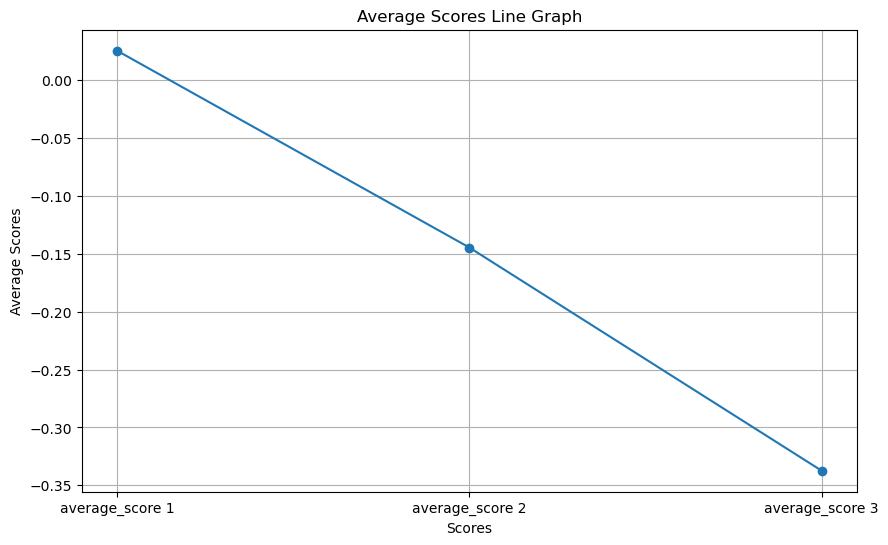

In [49]:
import matplotlib.pyplot as plt

# Assuming you have three average scores stored in variables average_score_1, average_score_2, and average_score_3
average_scores = [average_score1, average_score2, average_score3]
names = ["average_score 1", "average_score 2", "average_score 3"]

plt.figure(figsize=(10, 6))
plt.plot(names, average_scores, marker='o')
plt.xlabel('Scores')
plt.ylabel('Average Scores')
plt.title('Average Scores Line Graph')
plt.grid(True)
plt.show()


Even when graphed it is almost a perfect linear decrease as the films progress.